In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch
from torchtext import data
from torchtext import datasets

from torchtext.data import Field, BucketIterator

import json
from pathlib import Path

import random

import pandas as pd

import time
import spacy
import numpy as np

import math


In [ ]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/END/session-9/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/END/session-9/dev-v2.0.json')

In [ ]:
len(train_contexts), len(val_contexts)

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_answers[0]

In [ ]:
train_answers[0]
ans_start, ans_end, ans = [], [], []
for ii in range(len(train_answers)):
  ans_start.append(train_answers[ii]['answer_start'])
  ans_end.append(train_answers[ii]['answer_end'])
  ans.append(train_answers[ii]['text'])
print(len(ans_start), len(ans_end))

In [ ]:
df = pd.DataFrame(
    {'context': train_contexts,
     'question': train_questions,
     'answer' : ans
    })
df.head(5)

In [ ]:
Context = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)
Question = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)
Answer = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)

fields = [('context', Context),('question', Question), ('answer',Answer)]

In [ ]:
example = [data.Example.fromlist([df.context[i],df.question[i],df.answer[i]], fields) for i in range(df.shape[0])] 


squadDataset = data.Dataset(example, fields)

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

(train, valid, test) = squadDataset.split(split_ratio=[0.80, 0.1, 0.1], random_state=random.seed(SEED))

In [ ]:
valid, train, test

In [ ]:
len(train),len(valid),len(test)

In [ ]:
Context.build_vocab(train, min_freq = 2)
Question.build_vocab(train, min_freq = 2)
Answer.build_vocab(train, min_freq = 2)

In [ ]:
len(Context.vocab), len(Question.vocab), len(Answer.vocab)

In [ ]:
for i,ii in enumerate(valid):
  print(ii.question)
  print(ii.context)
  print(ii.answer)
  print("___________")
  if i == 4:
    break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test), sort = False,
    batch_size = BATCH_SIZE,
    device = device)

In [ ]:
print(len(valid_iterator))
for i in valid_iterator:
  print(i.context[0].shape)
  print(i.question[0].shape)
  print(i.answer[0].shape)
  break

In [ ]:
# for n, i in enumerate(train_iterator):
#   print(i.context[0].shape)
#   print(i.question[0].shape)
#   print(i.answer[0].shape)
#   print("------------------")
#   if n == 10:
#     break

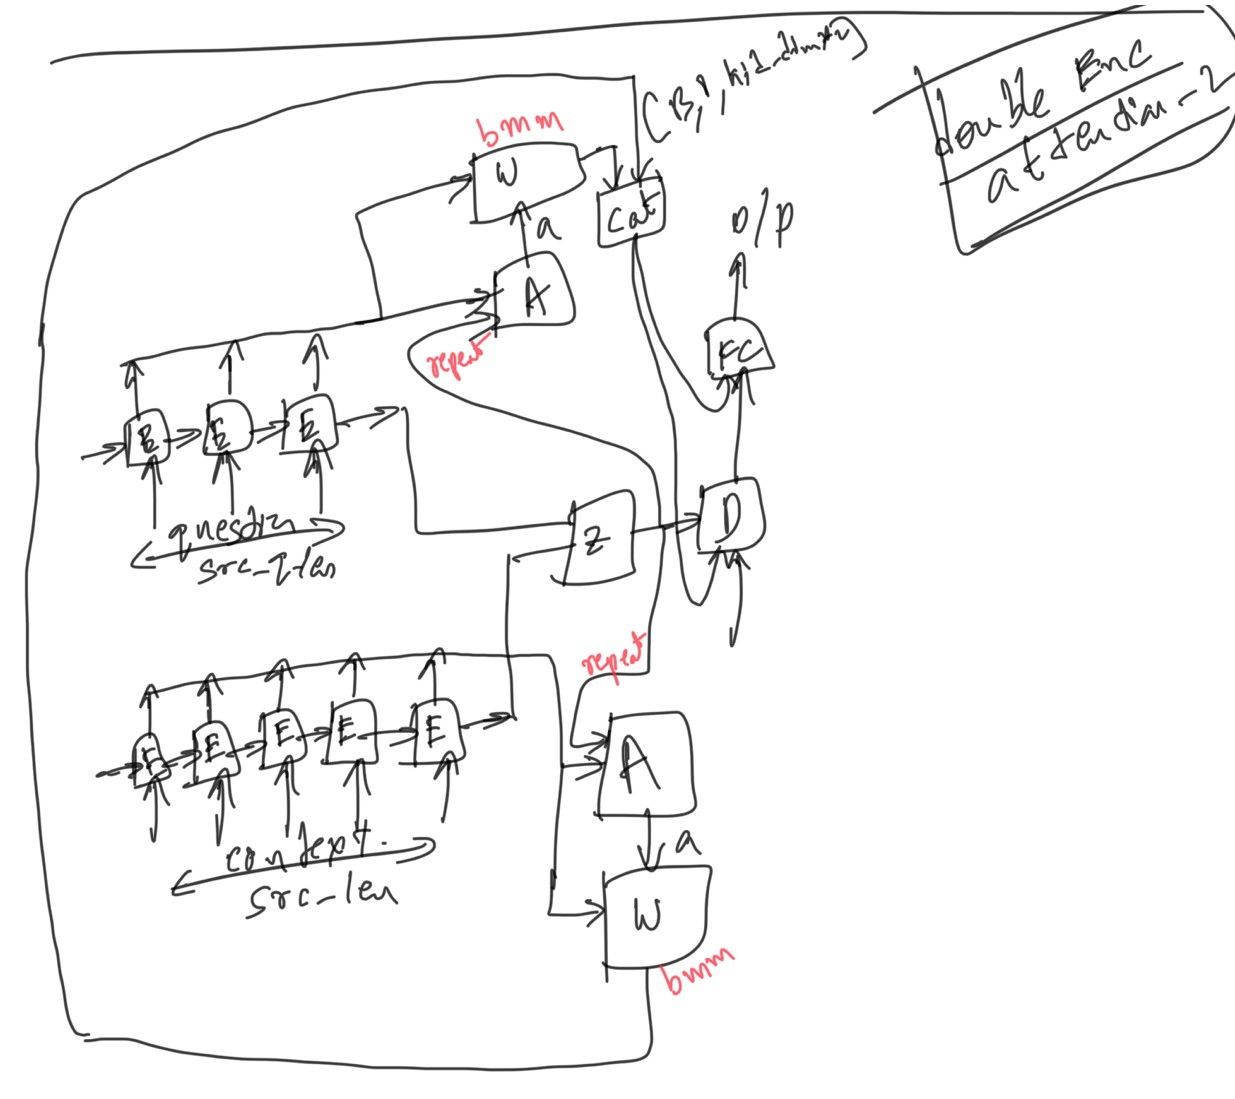

In [2]:
from IPython.display import Image
Image('att_2_seq2seq.jpg', width=1000, height=600)

Here the Decoder hidden vector will be repeated seperately for two decoders(context decode and the question decoder), src_len times for the context encoder and src_q_len times for the quesiotn encoder.
Here the attention is applied on the two source input encoders seperately together.

We can see in the above figure that he attention modules(A and W) are applied seperately for context encoder and question encoder.

Attention outputs of both the context and question encoders are concatinated to get the dimention 
**[batch size, 1, (enc hid dim * 2) * 2]**

First 2 is for bidirectionality and second 2 is for two encoders.


This tensor is passed to input of decoder LSTM and the decoder ouput dense layer.


**NOTE:** Role of Repeat and bmm(batch matrix multiplication)

**Repeat:** will repeat the current decoder hidstate source length number of times. 

**bmm:** Multiply the output of Block(A) with the outputs of the encoder input. This essentially gives the wightage to the words in the input source sentance.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2 * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2 * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, encoder_outputs_q):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a_c = self.attention(hidden, encoder_outputs)
        a_q = self.attention(hidden, encoder_outputs_q)
                
        #a_c = [batch size, src len]
        #a_q = [batch size, src q len]
        
        a_c = a_c.unsqueeze(1)
        a_q = a_q.unsqueeze(1)
        
        #a_c = [batch size, 1, src len]
        #a_q = [batch size, 1, src q len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        encoder_outputs_q = encoder_outputs_q.permute(1, 0, 2)

        # encoder_outputs = torch.cat((encoder_outputs, encoder_outputs_q), dim = 1)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        #encoder_outputs_q = [batch size, src q len, enc hid dim * 2]
        
        weighted_c = torch.bmm(a_c, encoder_outputs)
        weighted_q = torch.bmm(a_q, encoder_outputs_q)
        
        weighted = torch.cat((weighted_c, weighted_q), dim = 2)
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, (enc hid dim * 2) * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, encoder_q, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.encoder_q = encoder_q
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_1, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        encoder_outputs_q, hidden_q = self.encoder_q(src_1)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs, encoder_outputs_q)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(Context.vocab)
INPUT_DIM_Q = len(Question.vocab)
OUTPUT_DIM = len(Answer.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
enc_q = Encoder(INPUT_DIM_Q, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, enc_q, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = Answer.vocab.stoi[Answer.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
for i, batch in enumerate(train_iterator):
  print(batch.context[0].T.shape)
  break

In [ ]:
for i, batch in enumerate(valid_iterator):
  print(batch.context[0].T.shape)
  break

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.context[0]
        src_1 = batch.question[0]
        trg = batch.answer[0]
        
        optimizer.zero_grad()
        
        # print(src.shape, trg.shape)
        output = model(src, src_1, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # src = batch.src.T
            # trg = batch.trg.T
            src = batch.context[0]
            src_1 = batch.question[0]
            trg = batch.answer[0]

            output = model(src, src_1, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import spacy
import numpy as np

import random
import math

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 14m 2s
	Train Loss: 7.063 | Train PPL: 1167.946
	 Val. Loss: 6.225 |  Val. PPL: 505.424
Epoch: 02 | Time: 14m 5s
	Train Loss: 5.778 | Train PPL: 323.141
	 Val. Loss: 5.813 |  Val. PPL: 334.745
Epoch: 03 | Time: 14m 7s
	Train Loss: 4.423 | Train PPL:  83.343
	 Val. Loss: 5.976 |  Val. PPL: 394.023
Epoch: 04 | Time: 14m 5s
	Train Loss: 3.105 | Train PPL:  22.312
	 Val. Loss: 6.484 |  Val. PPL: 654.695
Epoch: 05 | Time: 13m 58s
	Train Loss: 2.364 | Train PPL:  10.633
	 Val. Loss: 6.797 |  Val. PPL: 895.489
Epoch: 06 | Time: 14m 0s
	Train Loss: 2.049 | Train PPL:   7.761
	 Val. Loss: 7.088 |  Val. PPL: 1197.407
Epoch: 07 | Time: 14m 3s
	Train Loss: 1.803 | Train PPL:   6.066
	 Val. Loss: 7.268 |  Val. PPL: 1434.326
Epoch: 08 | Time: 14m 12s
	Train Loss: 1.608 | Train PPL:   4.992
	 Val. Loss: 7.554 |  Val. PPL: 1908.140
Epoch: 09 | Time: 14m 9s
	Train Loss: 1.475 | Train PPL:   4.372
	 Val. Loss: 7.752 |  Val. PPL: 2325.657
Epoch: 10 | Time: 14m 14s
	Train Loss: 1.375 | T

In [ ]:
import time
import spacy
import numpy as np

import random
import math

N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 14m 4s
	Train Loss: 1.292 | Train PPL:   3.640
	 Val. Loss: 8.212 |  Val. PPL: 3685.169
Epoch: 02 | Time: 13m 53s
	Train Loss: 1.225 | Train PPL:   3.405
	 Val. Loss: 8.481 |  Val. PPL: 4820.267
Epoch: 03 | Time: 13m 59s
	Train Loss: 1.186 | Train PPL:   3.274
	 Val. Loss: 8.469 |  Val. PPL: 4766.419
